# Policy gradient algrorithm with BigDL

In [1]:
import random
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

from bigdl.dataset.transformer import Sample
from bigdl.nn.layer import *
from bigdl.util.common import *
from bigdl.optim.optimizer import *
from bigdl.nn.criterion import *

from rl.criterion import *

init_engine()

In [2]:
from keras import models
from keras.layers import Dense
from keras import optimizers

Using TensorFlow backend.


In [42]:
class PGAgent:
    def __init__(self, state_size, action_size, batch_size=32, gamma=0.95,learning_rate=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = gamma  # discount rate
        self.learning_rate = learning_rate
        self.model = self._build_model()
        self.value_func = self._build_vf()
        self.memory = deque(maxlen=2000)
        self.batch_size = batch_size

    def _build_model(self):
        model = Sequential()

        model.add(Linear(self.state_size, 24))
        model.add(ReLU())

        model.add(Linear(24, 24))
        model.add(ReLU())

        model.add(Linear(24, 1))
        model.add(Sigmoid())
        return model
    
    def _build_vf(self):
        model = models.Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=optimizers.Adam(lr=0.001))
        return model
    
    def train_val_func(self):
        if len(self.memory) < self.batch_size:
            pass
        else:
            minibatch = random.sample(self.memory, self.batch_size)
            for state, action, reward, next_state, done in minibatch:
                target = reward
                if not done:
                    target = (reward + self.gamma *
                              np.amax(self.value_func.predict(np.reshape(next_state, [1, state_size]))[0]))
                target_f = self.value_func.predict(np.reshape(next_state, [1, state_size]))
                target_f[0][action] = target
                self.value_func.fit(np.reshape(state, [1, state_size]), target_f, epochs=1, verbose=0)


    def act(self, state):
        result = self.model.forward(state)
        return 1 if result > np.random.random() else 0

In [4]:
import to_rdd

In [5]:
def play_game(agent, render=False):
    state = env.reset()
    memory = np.array([0,0,0,0])
    actions = np.array([])
    rewards = np.array([])
    for time in range(500):
        if render:
            env.render()
        memory = np.vstack((memory, state))
        action = agent.act(state)
        actions = np.append(actions, action)
        next_state, reward, done, _ = env.step(action)
        if done:
            reward = -10
        rewards = np.append(rewards, reward)
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state
        if done or time == 498:
            break
    return memory[1:], actions, rewards, time

In [6]:
def running_reward(actions, rewards, st_values, gamma):
    result = []
    run_rew = 0
    for action, reward, st_value in list(zip(actions, rewards, st_values))[::-1]:
        run_rew = run_rew*gamma + reward
        result.append([action, (run_rew - st_value)])
    return np.vstack(result[::-1])

In [16]:
def get_values(agent, states):
    result = []
    for state in states:
        values = agent.value_func.predict(np.reshape(state, [1, agent.state_size]))[0]
        prediction = agent.model.forward(state)
        result.append(values[0]*(1-prediction) + values[1]*prediction)
    return result

In [17]:
def play_n_games(agent, n=20):
    X_batch = np.array([0,0,0,0])
    y_batch = np.array([0,0])
    results = []
    for i in range(n):
        a, b, c, d = play_game(agent)
        X_batch = np.vstack((X_batch, a))
        st_values = get_values(agent, a)
        y_batch = np.vstack((y_batch, running_reward(b, c, st_values, agent.gamma)))
        agent.train_val_func()
        results.append(d)
    return X_batch[1:], y_batch[1:], results

In [44]:
env = gym.make('CartPole-v1')
sc = SparkContext.getOrCreate(create_spark_conf())
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = PGAgent(state_size, action_size)

[2017-11-15 14:54:08,434] Making new env: CartPole-v1


creating: createSequential
creating: createLinear
creating: createReLU
creating: createLinear
creating: createReLU
creating: createLinear
creating: createSigmoid


In [45]:
%%time
results = []
minimums = []
maximums = []
for t in range(1, 101):
    X_batch, y_batch, result = play_n_games(agent, n = 10)
    print(t, np.mean(result), np.var(result), result)
    results.append(np.mean(result))
    minimums.append(np.min(result))
    maximums.append(np.max(result))
    if result == 498:
        break
    rdd_sample = to_rdd.to_RDD(X_batch, y_batch, sc)
    batch_size = X_batch.shape[0] - X_batch.shape[0]%4
    optimizer = Optimizer(model=agent.model,
                                  training_rdd=rdd_sample,
                                  criterion=VanillaPGCriterion(),
                                  optim_method=Adam(learningrate=agent.learning_rate),
                                  end_trigger=MaxIteration(1),
                                  batch_size=batch_size)
    agent.model = optimizer.optimize()

1 21.8 151.56 [11, 16, 39, 46, 14, 17, 34, 8, 15, 18]
creating: createVanillaPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
2 31.6 434.64 [37, 47, 87, 28, 18, 23, 13, 25, 23, 15]
creating: createVanillaPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
3 24.5 153.45 [29, 40, 14, 49, 14, 31, 26, 21, 12, 9]
creating: createVanillaPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
4 24.6 44.44 [35, 33, 24, 20, 25, 26, 20, 12, 31, 20]
creating: createVanillaPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
5 23.8 151.76 [14, 36, 22, 20, 20, 19, 21, 18, 12, 56]
creating: createVanillaPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
6 27.1 96.49 [33, 43, 24, 36, 16, 32, 15, 28, 11, 33]
creating: createVanillaPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
7 23.5 1

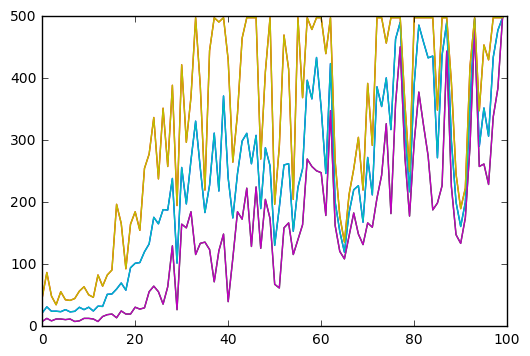

In [47]:
plt.plot(results)
plt.plot(minimums)
plt.plot(maximums)
plt.savefig('PGAC_BigDL_KerasVF_rew:-10_wo_Clip')
plt.show()

In [48]:
state = env.reset()
memory = np.array([0,0,0,0])
actions = np.array([])
rewards = np.array([])
for time in range(500):
    #memory = np.vstack((memory, state))
    value = agent.value_func.predict(np.reshape(state, [1,4]))
    prediction = agent.model.forward(state)
    rand = np.random.random()
    action = 1 if prediction > rand else 0
    next_state, reward, done, _ = env.step(action)
    print(value, prediction, rand, action)
    if done:
        reward = -10
    #rewards = np.append(rewards, reward)
    #agent.memory.append((state, action, reward, next_state, done))
    state = next_state
    if done or time == 498:
        break

[[ 20.14835548  20.14870834]] [ 0.54096794] 0.5497953405751451 0
[[ 20.22732925  20.20575905]] [ 0.90092808] 0.8669058044307526 1
[[ 20.1877346   20.18857574]] [ 0.54610932] 0.33315645176939956 1
[[ 20.12825012  20.13807297]] [ 0.11786696] 0.15001298513997618 0
[[ 20.15744781  20.15872955]] [ 0.53447866] 0.2836989551854334 1
[[ 20.09703445  20.10741234]] [ 0.1121738] 0.9674669811757151 0
[[ 20.12491035  20.12707901]] [ 0.51612091] 0.41095908724778285 1
[[ 20.06340027  20.07467079]] [ 0.1045789] 0.6293129285587388 0
[[ 20.0895195   20.09303474]] [ 0.49071753] 0.25891837808165175 1
[[ 20.02671814  20.03923035]] [ 0.09513292] 0.2519899313095524 0
[[ 20.05060005  20.05594063]] [ 0.45786512] 0.1675721795284424 1
[[ 19.98628426  20.0004158 ]] [ 0.0848713] 0.48540838731431435 0
[[ 20.00740623  20.01508331]] [ 0.41644186] 0.9104112795438462 0
[[ 20.07898331  20.06557083]] [ 0.85498863] 0.5434369716304273 1
[[ 20.03142548  20.04127312]] [ 0.39396271] 0.12205794533083847 1
[[ 19.96576118  19.983

In [86]:
X_batch, y_batch, result = play_n_games(agent, n = 5)
print(t, np.mean(result), result)

rdd_sample = to_rdd.to_RDD(X_batch, y_batch, sc)
optimizer = Optimizer(model=agent.model,
                              training_rdd=rdd_sample,
                              criterion=VanillaPGCriterion(),
                              optim_method=Adam(learningrate=agent.learning_rate),
                              end_trigger=MaxEpoch(1),
                              batch_size=4)
agent.model = optimizer.optimize()

creating: createMSECriterion
creating: createAdam
creating: createMaxEpoch
creating: createOptimizer
creating: createMSECriterion
creating: createAdam
creating: createMaxEpoch
creating: createOptimizer
creating: createMSECriterion
creating: createAdam
creating: createMaxEpoch
creating: createOptimizer
creating: createMSECriterion
creating: createAdam
creating: createMaxEpoch
creating: createOptimizer
creating: createMSECriterion
creating: createAdam
creating: createMaxEpoch
creating: createOptimizer
6 73.4 [104, 37, 78, 98, 50]
creating: createVanillaPGCriterion
creating: createAdam
creating: createMaxEpoch
creating: createOptimizer


In [87]:
for a, b in zip(get_values(agent, X_batch), y_batch):
    print(a, b)

[ 0.0827365] [  1.          19.81244469]
[ 0.10586917] [  1.          19.79413605]
[ 0.14731486] [  1.          19.75632858]
[ 0.18169846] [  0.          19.72058105]
[ 0.15204923] [  0.          19.73444366]
[ 0.11716782] [  0.          19.74938965]
[ 0.09595046] [  0.          19.74822617]
[ 0.10437021] [  1.          19.73132896]
[ 0.10042933] [  0.          19.72294617]
[ 0.10275005] [  0.          19.70770264]
[ 0.12931788] [  1.          19.68036461]
[ 0.10118809] [  1.         19.6823349]
[ 0.10844115] [  1.          19.66575623]
[ 0.14100969] [  0.          19.63124084]
[ 0.11370825] [  0.         19.6317997]
[ 0.10198044] [  0.          19.61933708]
[ 0.11848997] [  0.          19.59321022]
[ 0.15901318] [  1.          19.54726982]
[ 0.11368705] [  1.         19.5583744]
[ 0.1055854] [  0.          19.54346275]
[ 0.10970016] [  1.          19.51876068]
[ 0.10851577] [  0.          19.49891472]
[ 0.10673793] [  0.          19.47466278]
[ 0.13623157] [  1.          19.43192101]


In [75]:
agent.memory

deque([(array([ 0.02573658,  0.01537697, -0.04826151, -0.03206758]),
        0,
        1.0,
        array([ 0.02604412, -0.17902086, -0.04890286,  0.24500627]),
        False),
       (array([ 0.02604412, -0.17902086, -0.04890286,  0.24500627]),
        1,
        1.0,
        array([ 0.02246371,  0.01676422, -0.04400274, -0.06269197]),
        False),
       (array([ 0.02246371,  0.01676422, -0.04400274, -0.06269197]),
        1,
        1.0,
        array([ 0.02279899,  0.21248854, -0.04525658, -0.3689269 ]),
        False),
       (array([ 0.02279899,  0.21248854, -0.04525658, -0.3689269 ]),
        0,
        1.0,
        array([ 0.02704876,  0.01803786, -0.05263511, -0.09085042]),
        False),
       (array([ 0.02704876,  0.01803786, -0.05263511, -0.09085042]),
        1,
        1.0,
        array([ 0.02740952,  0.2138732 , -0.05445212, -0.39966418]),
        False),
       (array([ 0.02740952,  0.2138732 , -0.05445212, -0.39966418]),
        1,
        1.0,
        array([ 0

In [17]:
for a in y_batch:
    if a[1] > 0:
        print('a')